In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import nivapy3 as nivapy
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import seaborn as sn
import numpy as np

# Terrestrial fluxes

## Notebook 03: Compare simulated flow with observations

Here we compare simulated flows derived in notebook 02 with any observed discharge present within the area of interest. To do this, we:
- Find all stations with discharge data in HydAPI that are located within the catchments generated in notebook 01 and then filter the stations to only include ones that cover an acceptably large part of the catchment (using station metadata, the upstream catchment area)
- Download observations for the selected stations using HydAPI
- Compare simulated and observed (stats, plots) at the raw resolution, as well as monthly and annual.

## User inputs

In [2]:
# output_dir = "/home/jovyan/shared/common/JES/terrestrial_fluxes"
output_dir = "/home/jovyan/shared/common/catchment2coast/riv_fluxes"
cat_shp_name = "catchments_over_50km2.shp"
outlets_shp_name = "outlets_over_50km2.shp"

# Output time resolution for discharge series ('daily', 'monthly', 'annual').
# NVE's raw model output is daily. Monthly and annual series are calculated by averaging
t_res = "monthly"

# How many kinds of model data to read in? List, options are 'scale_vassoms', 'gts-api'
model_type_li = ['scale_vassoms', 'gts-api']

# Threshold for area_monitored / area_to_sea (discard stations where this ratio < drop_f)
drop_f = 0.7

# Start and end dates
st_dt = "2018-01-01"  # drop 2017, GTS API dodgy then
end_dt = "2023-12-31"

## Read in modelled data

In [3]:
# Frequency codes for resampling
resamp_dict = {"daily": "D", "monthly": "MS", "annual": "YS"}

if len(model_type_li) > 1:
    flow_csv_path = os.path.join(output_dir, "csv", "q_sim_both_methods.csv")
    df = pd.read_csv(flow_csv_path)

else:
    if 'scale_vassoms' in model_type_li:
        area_scale_fpath = os.path.join(output_dir, "csv", "flows_scale_vassoms.csv")
        df = pd.read_csv(area_scale_fpath)
        df = df.rename({'flow_m3/s': 'q_scale-vassoms'}, axis=1)

    elif 'gts-api' in model_type_li:
        q_gwb_fpath = os.path.join(output_dir, "csv", "flows_gts-api.csv")
        df = pd.read_csv(q_gwb_fpath)
        df = df.rename({'flow_m3/s': 'q_gts-api'}, axis=1)

    else:
        print('check your model_type_li and filepaths')

df

elvid        date  q_scale-vassoms  q_gts-api  q_sim-mean
0         2  2018-01-01         1.613591   0.767192    1.190391
1         2  2018-02-01         1.248788   0.767618    1.008203
2         2  2018-03-01         1.067233   0.433712    0.750473
3         2  2018-04-01         2.031468   0.399219    1.215343
4         2  2018-05-01        14.228752  16.028459   15.128605
...     ...         ...              ...        ...         ...
8419    873  2023-08-01         0.843937   1.140566    0.992251
8420    873  2023-09-01         0.777196   0.781822    0.779509
8421    873  2023-10-01         1.292026   1.509840    1.400933
8422    873  2023-11-01         0.691505   0.679889    0.685697
8423    873  2023-12-01         0.458099   0.324867    0.391483

[8424 rows x 5 columns]

## Find stations with observations in the domain of interest

In [4]:
# List all stations available on HydAPI
full_stn_df = nivapy.da.get_nve_hydapi_stations()
print(len(full_stn_df), "stations available in HydAPI.")

keep_cols = ['station_id', 'station_name', 'latitude', 'longitude',
                               'utmNorth_Z33', 'utmEast_Z33', 'masl', 'riverName',
                               'regineNo', 'drainageBasinArea', 'seriesList']
# Drop unwanted columns
full_stn_df = full_stn_df[keep_cols]


# Drop stations that don't have discharge data
def find_discharge_stations(row):
    has_q = False
    dict_list = row['seriesList']
    for dict in dict_list:
        param = dict['parameterName']
        if param == 'Vannføring':
            has_q = True
            break
    return has_q


full_stn_df['has_q'] = full_stn_df.apply(find_discharge_stations, axis=1)
full_stn_df = full_stn_df.loc[full_stn_df['has_q'] == True]

print(len(full_stn_df), "stations in HydAPI with discharge data")

1868 stations available in HydAPI.
609 stations in HydAPI with discharge data


In [5]:
# Find monitoring points that lie within the area of interest
# Simulated q is id'd using elvid. Need to assign an elvid to the observed monitoring points.
# Do this using nivapy's identify_point_in_polygon function

# Read in catchment shapefile
cat_gdf = gpd.read_file(os.path.join(output_dir, "shp", cat_shp_name))

# Find out which catchment polygon each point is in
stn_df = nivapy.spatial.identify_point_in_polygon(
    full_stn_df,
    cat_gdf,
    pt_col="station_id",
    poly_col="elvid",
    lat_col="latitude",
    lon_col="longitude",
)

# Drop rows where elvid is NaN (i.e. not in current domain)
stn_df = stn_df.dropna(subset="elvid", axis=0)

# Add catchment-to-sea area and make clear which area is which in col naming
stn_df = pd.merge(stn_df, cat_gdf[["elvid", "area_km2"]], on="elvid", how="left")
stn_df = stn_df.rename(
    {"area_km2": "model_area_km2", "drainageBasinArea": "obs_area_km2"}, axis=1
)

stn_df = stn_df.set_index('station_id')

# There are sometimes stations with no area attribute. For now just drop these
# FUTURE TO DO: delineate catchment and fill in area, unless they don't have area for a good reason?
# stn_df.loc[stn_df['obs_area_km2'].isna()].count()
stn_df = stn_df.dropna(subset='obs_area_km2', axis=0).copy()

# Drop observed stations with catchment areas < x the full area
stn_df['area_factor'] = stn_df['obs_area_km2'] / stn_df['model_area_km2']
stn_df['keep_stn'] = (stn_df['area_factor'] > drop_f)
stn_df = stn_df.loc[stn_df['keep_stn'] == True]
stn_df = stn_df.drop(['keep_stn'], axis=1)

# TODO: check for stations where catchment area is much larger than the observed area and flag

# Pick out the largest catchment area per elvid, and assume this is the most downstream point
# TODO - should maybe just get data for all stations, and then area-scale and average them?
# As don't know which the 'main' station is...
stn_df = stn_df.loc[stn_df.groupby('elvid')['obs_area_km2'].idxmax()]

stn_df

station_name  latitude  longitude  utmNorth_Z33  utmEast_Z33  \
station_id                                                                    
189.3.0        Tennevikvatn  68.64490   16.72235       7615747       569986   
191.2.0            Øvrevatn  68.85762   17.94107       7641320       618348   
186.2.0            Ånesvatn  69.06020   15.73423       7661250       529284   
194.4.0              Mevatn  69.23092   17.78346       7682613       610121   
194.1.0           Lysvatnet  69.41202   17.86190       7702931       612279   
203.2.0           Jægervatn  69.73168   19.86212       7743432       687806   
205.3.0         Skibotn bru  69.36507   20.27375       7704001       707197   
206.2.0            Holm bru  69.47787   20.88023       7718702       729757   
206.3.0       Manndalen bru  69.52389   20.52562       7722523       715471   
208.3.0     Svartfossberget  69.52854   21.38166       7726291       748701   
212.11.0              Kista  69.82630   23.51681       7769359       826880   
209.4.0         Lillefossen  69.78563   21.91785       7757075       766280   
208.2.0        Oksfjordvatn  69.90022   21.37681       7767523       744188   
234.18.0         Polmak nye  70.07034   28.01601       7826523       991883   
212.48.0           Sagafoss  69.95550   23.40874       7783072       820772   
212.49.0            Halsnes  70.02644   22.94164       7788532       802014   
223.2.0             Lombola  70.13985   24.76063       7811095       868698   
213.2.0        Leirbotnvatn  70.10667   23.55344       7800555       823898   
200.4.0      Skogsfjordvatn  69.98093   19.10412       7769022       656700   
213.4.0            Kvalsund  70.48684   23.95331       7844730       832718   

            masl             riverName regineNo  obs_area_km2  \
station_id                                                      
189.3.0       40          Tennevikelva   189.2A         85.41   
191.2.0       10           Salangselva   191.A5        526.02   
186.2.0       12                 Åelva   186.2B         47.04   
194.4.0       17  Lakselva fra Trollbu    194.A        180.43   
194.1.0       25               Lyselva  194.3C0        129.68   
203.2.0        4             Jægerelva   203.8B         93.75   
205.3.0        9     Skibotnvassdraget   205.A1        727.22   
206.2.0       27     Kåfjordvassdraget  206.A10        345.29   
206.3.0       21          Manndalselva  206.1A0        200.40   
208.3.0      102       Reisavassdraget  208.B72       1932.29   
212.11.0      62        Altavassdraget  212.B31       6181.80   
209.4.0       26             Navitelva  209.3A0        330.60   
208.2.0        9              Fiskelva  208.4B0        265.83   
234.18.0      17                  Tana   234.C0      14161.40   
212.48.0      27             Tverrelva  212.6A0        234.24   
212.49.0      37              Halselva   212.2A        145.05   
223.2.0       59          Stabburselva   223.B0        877.14   
213.2.0      161  Leirbotnelva (laksel   213.1B        135.47   
200.4.0       20        Skogsfjordelva   200.6B        136.01   
213.4.0       19          Kvalsundelva  213.6A0        124.80   

                                                   seriesList  has_q  elvid  \
station_id                                                                    
189.3.0     [{'parameterName': 'Vannstand', 'parameter': 1...   True   53.0   
191.2.0     [{'parameterName': 'Vannstand', 'parameter': 1...   True   94.0   
186.2.0     [{'parameterName': 'Vannstand', 'parameter': 1...   True  141.0   
194.4.0     [{'parameterName': 'Vannstand', 'parameter': 1...   True  303.0   
194.1.0     [{'parameterName': 'Vannstand', 'parameter': 1...   True  328.0   
203.2.0     [{'parameterName': 'Vannstand', 'parameter': 1...   True  360.0   
205.3.0     [{'parameterName': 'Vannstand', 'parameter': 1...   True  374.0   
206.2.0     [{'parameterName': 'Vannstand', 'parameter': 1...   True  435.0   
206.3.0     [{'parameterName': 'Vannstand', 'parameter'

/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


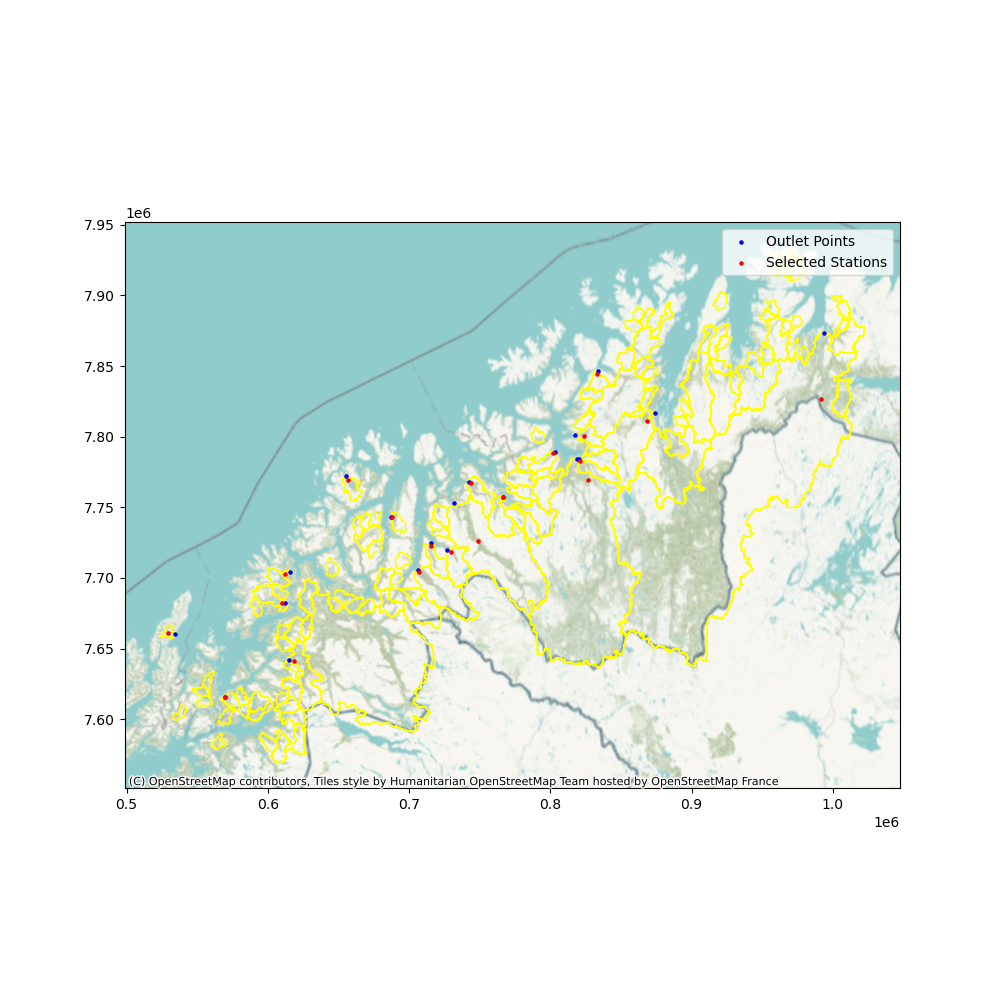

In [6]:
# Quick interactive plot to check matched outlet and monitoring points

%matplotlib widget

# Read in catchment outlet point shapefile
outlet_gdf = gpd.read_file(os.path.join(output_dir, "shp", outlets_shp_name))

# Convert select_stn_df to GeoDataFrame
geometry = [Point(xy) for xy in zip(stn_df['utmEast_Z33'], stn_df['utmNorth_Z33'])]
stn_gdf = gpd.GeoDataFrame(stn_df, geometry=geometry, crs=outlet_gdf.crs)

# Plotting the matched points from both dataframes using contextily openStreetMap as basemap
matched_outlet_gdf = outlet_gdf[outlet_gdf['elvid'].isin(stn_gdf['elvid'])]

fig, ax = plt.subplots(figsize=(10, 10))
cat_gdf.plot(ax=ax, facecolor='none', edgecolor='yellow')
matched_outlet_gdf.plot(ax=ax, color='blue', markersize=5, label='Outlet Points')
stn_gdf.plot(ax=ax, color='red', markersize=5, label='Selected Stations')
ctx.add_basemap(ax, crs=outlet_gdf.crs.to_string())

plt.legend()
plt.show()

## Download observed data

Future improvement: rather than just selecting most downstream gauging station, instead do a mean of [elvid, date] grouping

In [7]:
# Parameters to download
par_ids = [1001]  # Daily mean discharge

# Get daily mean discharge data
qobs_df_li = []

# For flexibility, in case want to download some subset
download_sites_df = stn_df.reset_index()

# Keep tabs on sites that fail, to drop them later
failed_site_li = []

for index, row in download_sites_df.iterrows():
    try:
        station_id = row['station_id']
        station_name = row['station_name']

        obs_df = nivapy.da.query_nve_hydapi([station_id], par_ids, st_dt, end_dt, resolution=1440)
        obs_df.set_index('datetime', inplace=True)

        # Area-scale values
        obs_df['value'] = obs_df['value'] / row['area_factor']

        # Just keep observed discharge column and resample to output frequency
        obs_df = obs_df[['value']].resample(resamp_dict[t_res]).mean()

        # Add elvid
        obs_df['elvid'] = row['elvid']

        qobs_df_li.append(obs_df)
        print(f"Downloaded data for {station_name}, {station_id}")
    except KeyError:
        print(f"KeyError for {station_name}, {station_id}")
        failed_site_li.append(station_id)
        continue

# Make columns match df_long
qobs_df = pd.concat(qobs_df_li, axis=0)
qobs_df.index = qobs_df.index.date  # remove time and timezone info
qobs_df.index.name = 'date'
qobs_df = qobs_df.reset_index()
qobs_df = qobs_df[['elvid', 'date', 'value']].copy()

# Save
qobs_df.to_csv(os.path.join(output_dir, "csv", "observed_q.csv"), index=False)

# Save locations of observed q stations e.g. for plotting
# First, remove any sites where the data download failed
stn_df = stn_df.drop(failed_site_li, axis=0)
stn_df.to_csv(os.path.join(output_dir, "csv", "observed_q_stations.csv"))

qobs_df

Downloaded data for Tennevikvatn, 189.3.0
Downloaded data for Øvrevatn, 191.2.0
Downloaded data for Ånesvatn, 186.2.0
Downloaded data for Mevatn, 194.4.0
Downloaded data for Lysvatnet, 194.1.0
Downloaded data for Jægervatn, 203.2.0
Downloaded data for Skibotn bru, 205.3.0
Downloaded data for Holm bru, 206.2.0
Downloaded data for Manndalen bru, 206.3.0
Downloaded data for Svartfossberget, 208.3.0
Downloaded data for Kista, 212.11.0
Downloaded data for Lillefossen, 209.4.0
Downloaded data for Oksfjordvatn, 208.2.0
Downloaded data for Polmak nye, 234.18.0
Downloaded data for Sagafoss, 212.48.0
Downloaded data for Halsnes, 212.49.0
Downloaded data for Lombola, 223.2.0
Downloaded data for Leirbotnvatn, 213.2.0
Downloaded data for Skogsfjordvatn, 200.4.0
Downloaded data for Kvalsund, 213.4.0


elvid        date     value
0      53.0  2018-01-01  0.912142
1      53.0  2018-02-01  0.786934
2      53.0  2018-03-01  0.241845
3      53.0  2018-04-01  2.587106
4      53.0  2018-05-01  9.428712
...     ...         ...       ...
1435  761.0  2023-08-01  1.603585
1436  761.0  2023-09-01  2.753989
1437  761.0  2023-10-01  3.124041
1438  761.0  2023-11-01  1.531794
1439  761.0  2023-12-01  0.606505

[1440 rows x 3 columns]

## Join simulated and observed and plot

In [9]:
# Join HBV and observed data
qobs_df['par'] = 'q_obs'

df_long = df.melt(id_vars=["elvid", "date"], var_name="par")
df_long = pd.concat([df_long, qobs_df])

df_long['date'] = pd.to_datetime(df_long['date'])
df_long = df_long.reset_index(drop=True)

# Just pick out outlets with observed data
elvids = list(stn_df['elvid'])
df_filtered = df_long[df_long["elvid"].isin(elvids)]

df_filtered

elvid       date              par     value
720     53.0 2018-01-01  q_scale-vassoms  1.098760
721     53.0 2018-02-01  q_scale-vassoms  0.803162
722     53.0 2018-03-01  q_scale-vassoms  0.731297
723     53.0 2018-04-01  q_scale-vassoms  2.096607
724     53.0 2018-05-01  q_scale-vassoms  7.308714
...      ...        ...              ...       ...
26707  761.0 2023-08-01            q_obs  1.603585
26708  761.0 2023-09-01            q_obs  2.753989
26709  761.0 2023-10-01            q_obs  3.124041
26710  761.0 2023-11-01            q_obs  1.531794
26711  761.0 2023-12-01            q_obs  0.606505

[5760 rows x 4 columns]

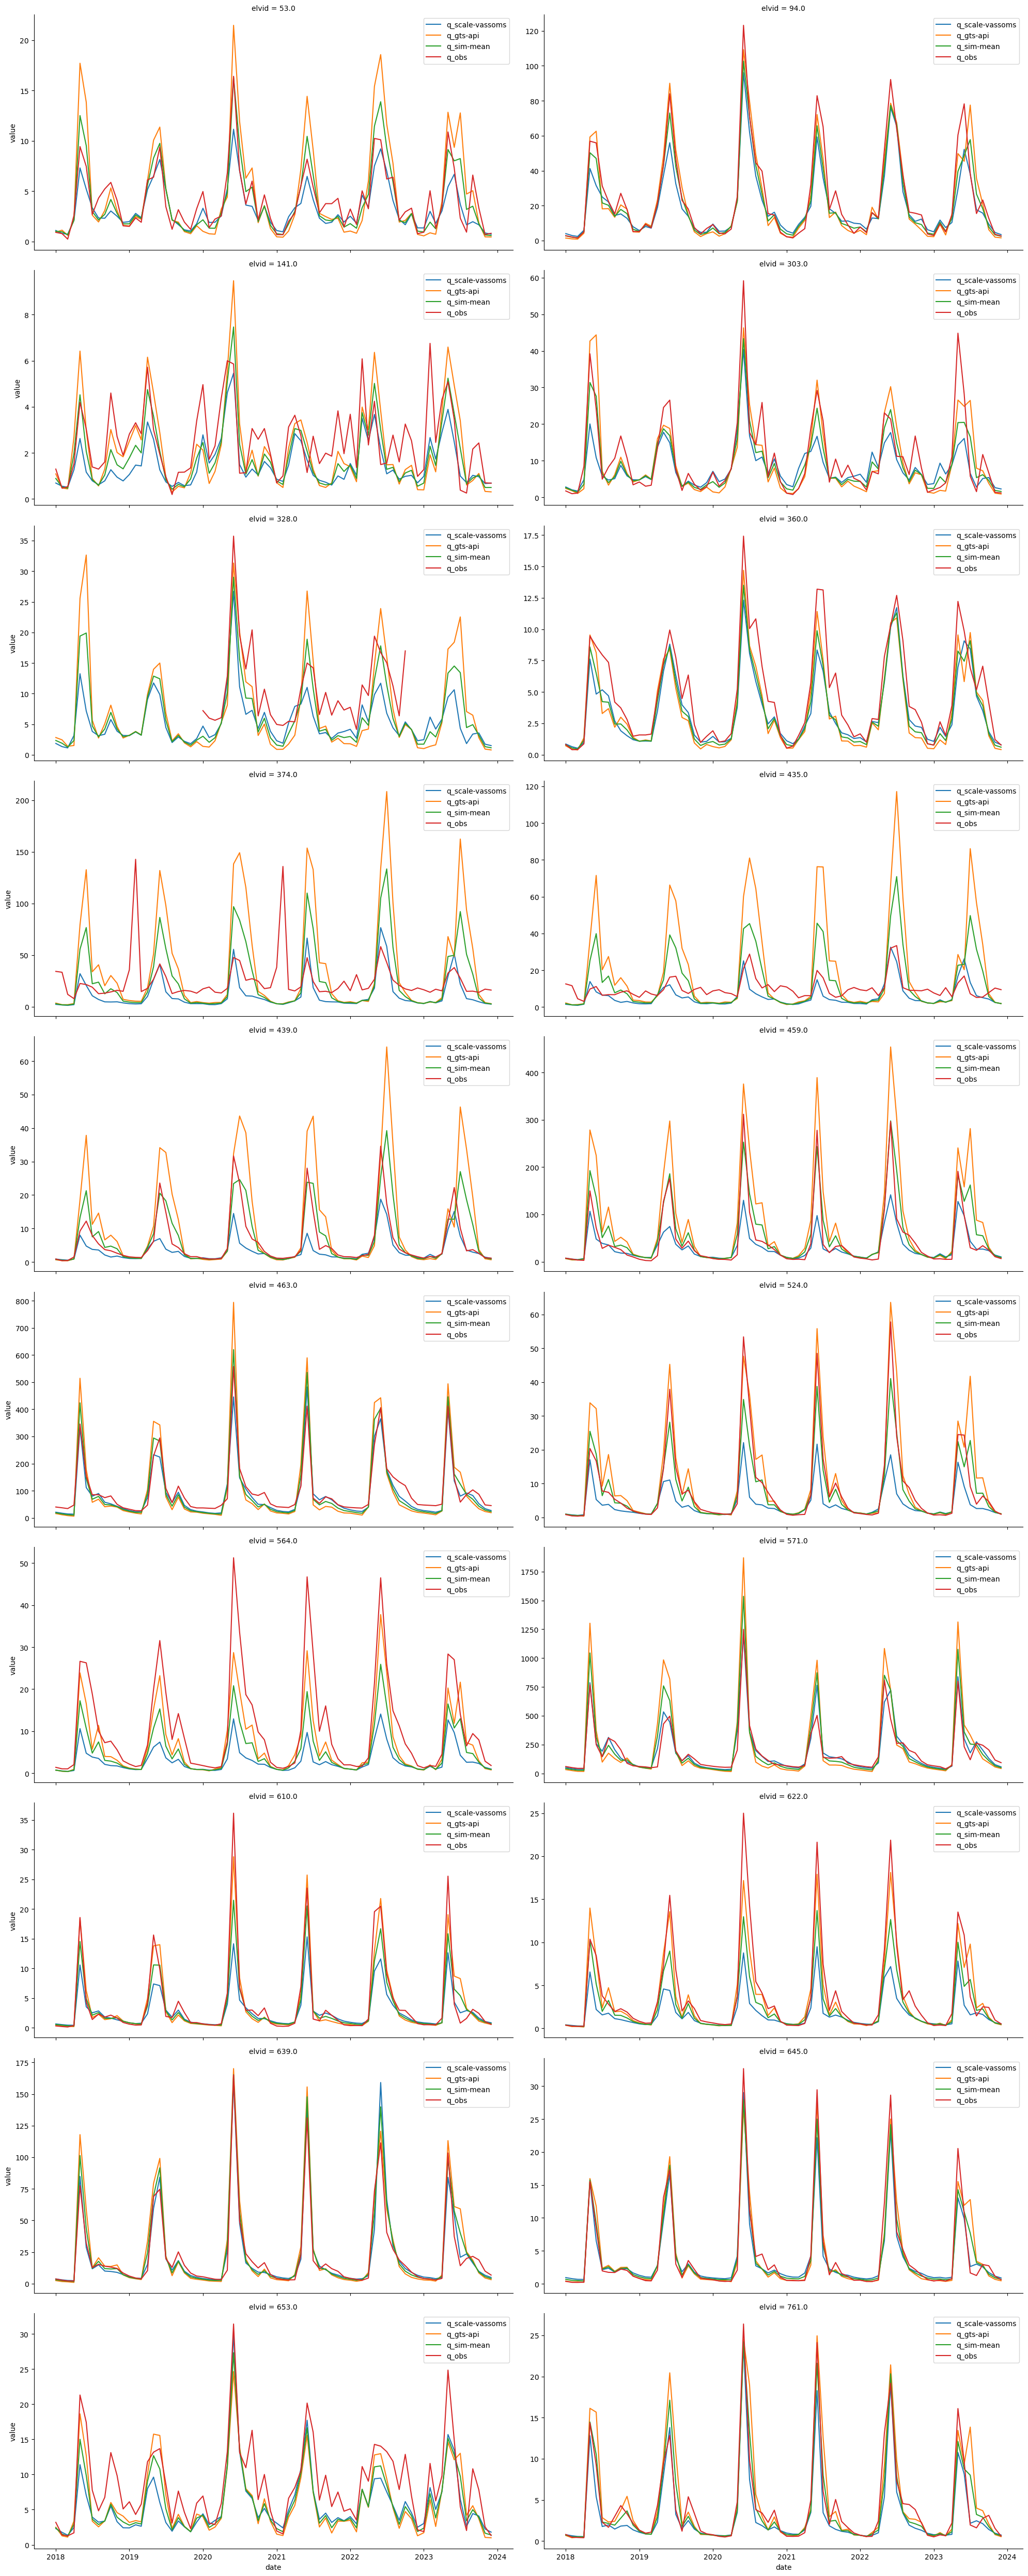

In [10]:
# Plot
%matplotlib inline

plt.close('all')

# Plot
g = sn.relplot(
    data=df_filtered,
    x="date",
    y="value",
    hue="par",
    col="elvid",
    col_wrap=2,
    kind="line",
    facet_kws={"sharey": False, "sharex": True, "legend_out": False},
    aspect=2,
)

handles, labels = g.axes.flat[0].get_legend_handles_labels()
for ax in g.axes.flat:
    ax.legend(handles, labels)

plt.show()

**Comments:**
- Graphs useful for picking out sites where observations are short and rubbish. Haven't automated doing this in code yet, rather am making a note of dodgy elvids and then dropping them from observations before replacing simulated with observed (next notebook).
- Simulated is expeted to be different to observed in catchments where have lots of hydro. See this particularly in some of the smaller stations (not the hovedelv so much).

## Model performance stats

In [31]:
def nash_sutcliffe(observed, simulated):
    """
    Calculate the Nash-Sutcliffe efficiency coefficient
    """
    return 1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2))


def calculate_ns_values(df_pivot, obs_col, sim_col_li):
    """
    Calculate Nash-Sutcliffe efficiency for each 'elvid'
    """
    ns_values = {}
    for elvid in df_pivot['elvid'].unique():
        df_elvid = df_pivot[df_pivot['elvid'] == elvid]
        ns_dict = {}
        for sim_col in sim_col_li:
            ns = nash_sutcliffe(df_elvid[obs_col], df_elvid[sim_col])
            ns_dict[sim_col] = ns
        ns_values[elvid] = ns_dict

    ns_df = pd.DataFrame.from_dict(ns_values, orient='index').reset_index()
    ns_df = ns_df.rename({'index': 'elvid'}, axis=1)
    ns_df = ns_df.set_index('elvid').round(2)
    return ns_df


# Function to determine the column with the higher ns value
def determine_best(row, columns):
    best_column = columns[0]
    for column in columns[1:]:
        if row[column] > row[best_column]:
            best_column = column
    return best_column


def summary_output(ns_df, columns):
    print("Mean NS:")
    print(ns_df[columns].mean())

    print("\nMedian NS:")
    print(ns_df[columns].median())

    best_s = ns_df.apply(determine_best, axis=1, columns=columns)
    count_best_s = best_s.value_counts()
    print("\nNumber of sites where each method was best:")
    print(count_best_s)

    print("\nOverall best method:")
    print(best_s.mode()[0])

In [32]:
df_pivot = df_filtered.pivot_table(index=['elvid', 'date'], columns='par', values='value').reset_index()

# TO DO: work sim_cols out automatically
sim_cols = ['q_scale-vassoms', 'q_gts-api', 'q_sim-mean']
# sim_cols = ['q_scale-vassoms']

# Raw frequency
ns_df = calculate_ns_values(df_pivot, 'q_obs', sim_cols)
summary_output(ns_df, columns=sim_cols)

Mean NS:
q_scale-vassoms    0.5160
q_gts-api         -0.7705
q_sim-mean         0.3860
dtype: float64

Median NS:
q_scale-vassoms    0.615
q_gts-api          0.700
q_sim-mean         0.760
dtype: float64

Number of sites where each method was best:
q_sim-mean         12
q_gts-api           4
q_scale-vassoms     4
Name: count, dtype: int64

Overall best method:
q_sim-mean


**Comment:**

Based on results of the statistical comparison, can choose the best method overall and just use that everywhere. A possible future extension could be to look in a bit more detail as to whether one method performs better in certain places/catchment types. Below, we start looking to see if there is a catchment area effect. Other things to look at could be topography (mountainuos vs flat) and distance to coast.

In [28]:
# Monthly, if the resolution wasn't already monthly then resample & then repeat above
if t_res == 'daily':
    monthly_mean_df = df_pivot.set_index('date').copy()
    monthly_mean_df = monthly_mean_df.groupby('elvid').resample('ME').mean()
    monthly_mean_df = monthly_mean_df.reset_index()

    monthly_ns_df = calculate_ns_values(monthly_mean_df)
    summary_output(monthly_ns_df)

    plt.close('all')
    %matplotlib inline

    monthly_df_long = monthly_mean_df.melt(id_vars=["elvid", "date"], var_name="par")

    # Plot
    g = sn.relplot(
        data=monthly_df_long,
        x="date",
        y="value",
        hue="par",
        col="elvid",
        col_wrap=2,
        kind="line",
        facet_kws={"sharey": False, "sharex": True, "legend_out": False},
        aspect=2,
    )

    handles, labels = g.axes.flat[0].get_legend_handles_labels()
    for ax in g.axes.flat:
        ax.legend(handles, labels)

In [33]:
# Annual sums
annual_df = df_pivot.set_index('date').copy()
annual_df = annual_df.dropna(how='any', axis=0)
annual_df = annual_df.groupby('elvid').resample('YE').sum()
annual_df = annual_df.drop(['elvid'], axis=1)
annual_df = annual_df.reset_index()

annual_ns_df = calculate_ns_values(annual_df, 'q_obs', sim_cols)
summary_output(annual_ns_df, sim_cols)

Mean NS:
q_scale-vassoms   -4.3385
q_gts-api         -4.4630
q_sim-mean        -1.7495
dtype: float64

Median NS:
q_scale-vassoms   -3.360
q_gts-api         -0.665
q_sim-mean        -0.130
dtype: float64

Number of sites where each method was best:
q_gts-api          10
q_sim-mean          8
q_scale-vassoms     2
Name: count, dtype: int64

Overall best method:
q_gts-api


**Comment:**

Do we see the same result with annual sums as we do with daily/seasonal patterns?

In the case of Troms & Finnmark hovedelv, no. The overall best method is actually gts-api in terms of being the best at most individual sites. But gts-api was a lot worse than the mean when it came to monthly mean discharge. So how to choose what to use for modelling? Depends what we care most about? i.e. getting seasonality right or getting annual fluxes right. In this case, might choose mean for seasonality, gts-api for annual fluxes. Although the mean was only worse than gts-api at two sites, and had the highest (though still negative) median NS.

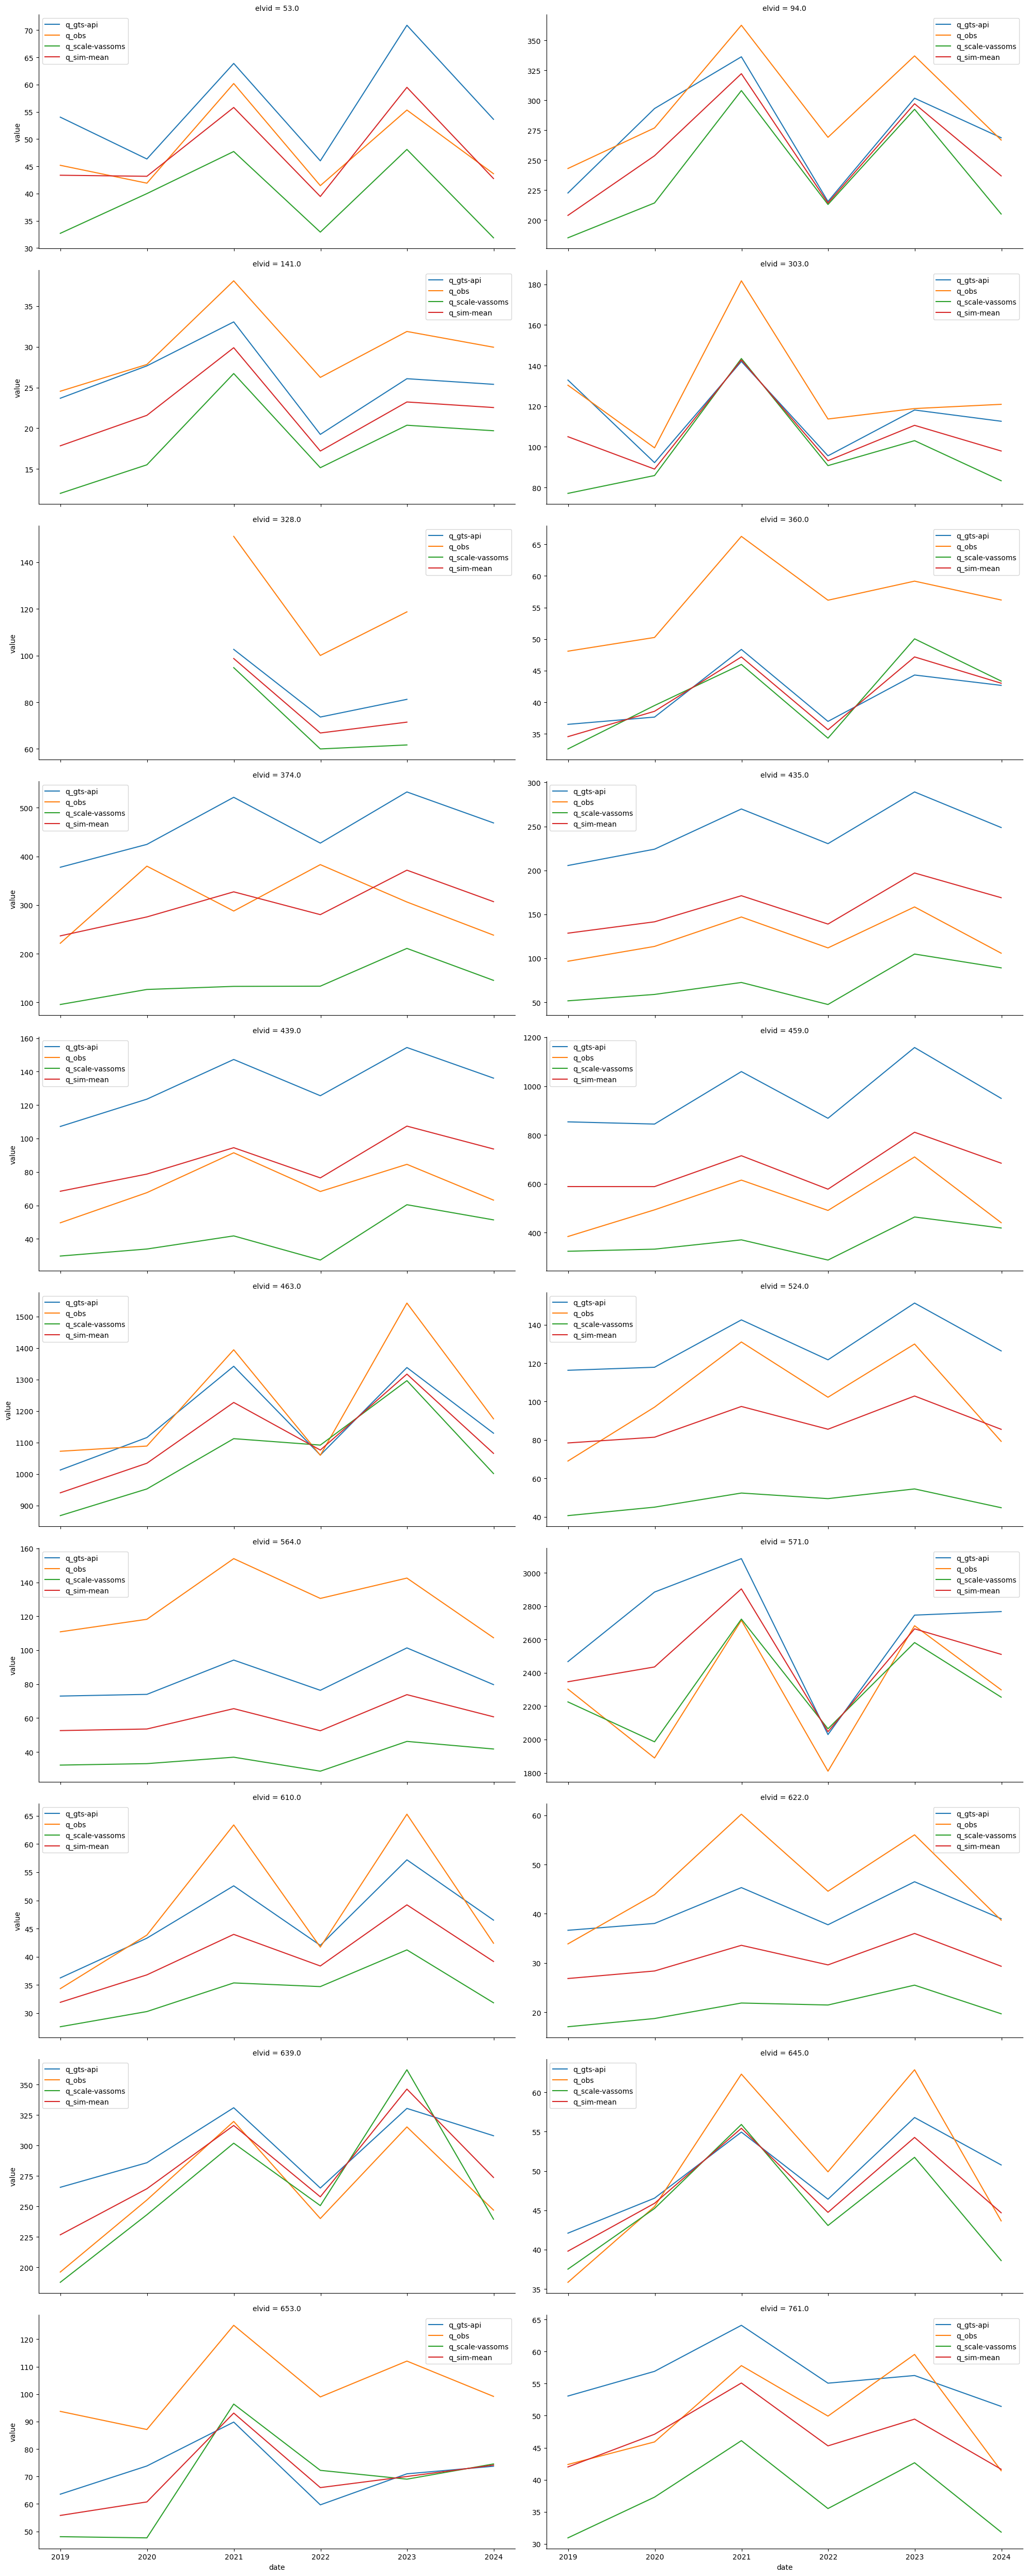

In [27]:
plt.close('all')
%matplotlib inline

annual_df_long = annual_df.melt(id_vars=["elvid", "date"], var_name="par")

# Plot
g = sn.relplot(
    data=annual_df_long,
    x="date",
    y="value",
    hue="par",
    col="elvid",
    col_wrap=2,
    kind="line",
    facet_kws={"sharey": False, "sharex": True, "legend_out": False},
    aspect=2,
)

handles, labels = g.axes.flat[0].get_legend_handles_labels()
for ax in g.axes.flat:
    ax.legend(handles, labels)

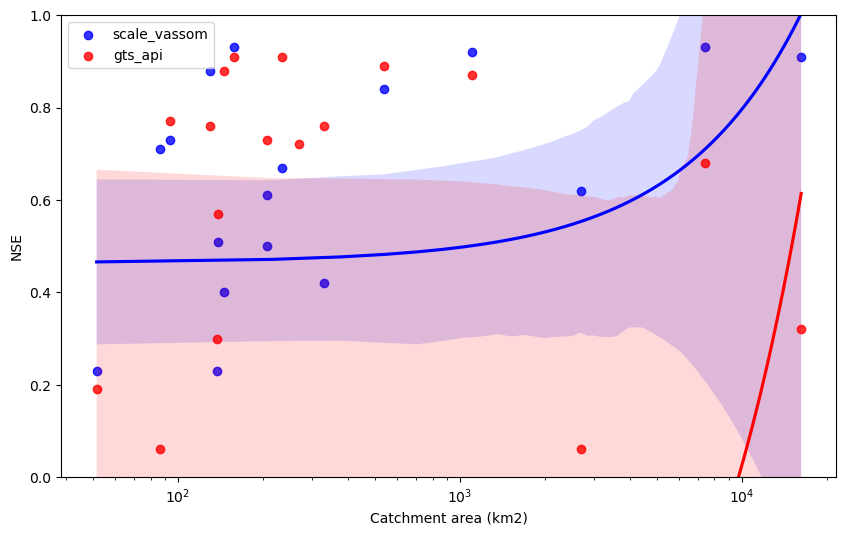

In [22]:
# See whether there's a link between NS and area, and performance of the two versions

# Create the mapping Series
elvid_area_map = stn_gdf.set_index('elvid')['model_area_km2']

# Map the values to the 'catch_area' column in ns_df
ns_df['catch_area'] = ns_df.index.map(elvid_area_map)

plt.figure(figsize=(10, 6))

# plot_df = ns_df.loc[ns_df['gts_api'] > 0]
plot_df = ns_df

# Scatterplot and regression line for y1 vs x1
sn.regplot(x='catch_area', y='q_scale-vassoms', data=plot_df, scatter_kws={'color': 'blue'},
           line_kws={'color': 'blue'}, label='scale_vassom')

# Scatterplot and regression line for y2 vs x1
sn.regplot(x='catch_area', y='q_gts-api', data=plot_df, scatter_kws={'color': 'red'}, line_kws={'color': 'red'}, label='gts_api')

plt.ylim(ymin=0, ymax=1)
plt.xscale('log')

# Add labels and legend
plt.xlabel('Catchment area (km2)')
plt.ylabel('NSE')
plt.legend()

plt.show()


**Comment:**
GTS-API maybe slightly better for smaller catchments. Scaled vassdragsområde data maybe slightly better for larger catchments

In [38]:
# print(stn_gdf['elvid'].duplicated().sum())
# duplicates = stn_gdf[stn_gdf['elvid'].duplicated(keep=False)]
# print("Duplicates in 'elvid' column:")
# print(duplicates)

# # Check for duplicates in ns_df
# print(ns_df.index.duplicated().sum())